# Modeling

In [1]:
# =========================================
# 1) IMPORT ALL REQUIRED LIBRARIES
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# scikit-learn / imblearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# xgboost, ensure xgboost is installed
from xgboost import XGBClassifier


url = 'DF_Model.csv'
random_state = 42
test_size = 0.3

# =========================================
# 2) INTRODUCTION & MOTIVATION
# =========================================

GOAL:
 - We have transaction-level data (DF_Model.csv) describing clients.
 - Our objective: Identify which clients have the highest propensity to be 
   reactivated after 2 years without purchases.

PLAN:
 1) Read the CSV.
 2) Explore data & note shape, columns, types.
 3) Convert from transaction-level to client-level (one row per client).
 4) Split into train/test sets.
 5) Build multiple models: Logistic, Random Forest, XGBoost.
    - We'll tune each model specifically for precision or recall via GridSearch.
 6) Compare results on test set for precision, recall, and F1 via bar charts.
 7) Discuss which approach is 'best' based on business needs.


In [2]:
# =========================================
# 3) DATA LOADING
# =========================================
df = pd.read_csv(url)
df.head()

,client_id,client_create_date,region,trade_sector,n_employees,economic_pot,eco_pot_class,risk_cat,yyyymm,item_id,...,sales_channel,net,family_code,group_code,sales_id,n_purchases,sales_net,time_diff_prec,time_diff_next,target
0,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,12585,...,C,937.94,XBXV2EB,XBXV2EB0102,9306_201709,2,1579.03,NaN,1126.0,1
1,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,13431,...,C,641.09,XBXV2AB,XBXV2AB0102,9306_201709,2,1579.03,NaN,1126.0,1
2,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2017-09-01,1380,...,C,0.00,XBXV2EB,XBXV2EB0102,9306_201709,2,1579.03,NaN,1126.0,1
3,9306,2005-11-15,BZ,11000,6,8659.81,D,3d,2020-10-01,3493,...,C,1341.14,XBXV1AF,XBXV1AF0201,9306_202010,2,1341.14,1126.0,NaN,0
4,8321,2005-11-15,LE,15500,2,681.26,E,T8,2021-11-01,1657,...,B,190.15,XAEG1AA,XAEG1AA0103,8321_202111,7,190.15,123.0,NaN,0


In [3]:
# =========================================
# 4) AGGREGATING TO CLIENT-LEVEL
# =========================================
# We assume 'client_id' is the unique identifier for each client.
# We'll create one row per client with aggregated features,
# plus a target that is 1 if they were reactivated, 0 otherwise.

df_agg = df.groupby('client_id', as_index=False).agg({
    'region': 'first',           # first known region
    'trade_sector': 'first',     # could also keep as numeric / transform
    'n_employees': 'mean',
    'economic_pot': 'mean',      # average potential
    'eco_pot_class': 'first',
    'risk_cat': 'first',
    'net': 'mean',                # mean net across all transactions
    'target': 'max',              # if any transaction had target=1 => 1
    'item_id': 'first',
    'flg_tool': 'first',
    'sales_channel': 'first',
    'family_code': 'first',
    'n_purchases': 'max'
})


print("Aggregated Data Shape:", df_agg.shape)
print("Sample Aggregated Rows:")
display(df_agg.head())


Aggregated Data Shape: (85289, 14)
Sample Aggregated Rows:


,client_id,region,trade_sector,n_employees,economic_pot,eco_pot_class,risk_cat,net,target,item_id,flg_tool,sales_channel,family_code,n_purchases
0,1,VT,22100,2.0,4528.46,E,3d,19.186667,0,13742,0,D,XAEC4AA,1
1,2,NO,13500,2.0,4432.42,E,3d,119.460000,0,9778,1,A,XAEP3CC,2
2,3,BA,21100,3.0,5000.00,E,3d,87.300000,0,585,1,B,XAEP3DA,6
3,4,MC,22100,4.0,5000.00,E,3d,121.480000,0,1731,0,A,XBCF2AA,1
4,5,AN,13500,2.0,4432.42,E,3d,91.876667,0,2473,1,C,XAEC3AA,1


In [ ]:
df_agg.info()

In [4]:
# =========================================
# 5) TRAIN/TEST SPLIT & BASIC PREPROCESSING
# =========================================

# X = all features except client_id & target
X = df_agg.drop(['client_id','target'], axis=1)
y = df_agg['target']

# Split data (stratify helps preserve class proportions)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_size, 
    random_state=random_state,
    stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

# Define columns to pass through
passthrough_cols = ['flg_tool']
# Identify numeric vs. categorical columns
# (You can refine these choices.)
numeric_cols = ['n_employees','economic_pot','net','n_purchases']
cat_cols = ['region','eco_pot_class','risk_cat','sales_channel']  # trade_sector could be included if desired

# Preprocessing pipelines
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", RobustScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, numeric_cols),
    ("cat", cat_pipe, cat_cols),
    ("passthrough", "passthrough", passthrough_cols)
])

print("Preprocessing set up. We can now feed it into a pipeline.")


Train shape: (59702, 12), Test shape: (25587, 12)
Preprocessing set up. We can now feed it into a pipeline.


In [5]:
# =========================================
# 6) CLASS IMBALANCE & SCORING FOR PRECISION vs. RECALL
# =========================================
# We'll do two sets of GridSearch for each model:
#  1) 'Precision' => scoring=precision_scorer
#  2) 'Recall'    => scoring=recall_scorer
# We'll use class_weight or scale_pos_weight to handle imbalance 
# while preserving the original data distribution.

precision_scorer = make_scorer(precision_score, pos_label=1)
recall_scorer    = make_scorer(recall_score,    pos_label=1)

results = []

In [6]:
# =========================================
# 7) MODEL 1: LOGISTIC REGRESSION
# =========================================

pipe_log = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42))
])

param_log = {
    "clf__C": [0.1, 1.0, 10],
    "clf__class_weight": [None, "balanced"]  # Could also try dict like {0:1,1:5} etc.
}

# --- (A) Optimize for PRECISION ---
grid_log_prec = GridSearchCV(
    estimator=pipe_log,
    param_grid=param_log,
    scoring=precision_scorer,
    cv=3
)
grid_log_prec.fit(X_train, y_train)

best_log_prec = grid_log_prec.best_estimator_
y_pred_log_prec = best_log_prec.predict(X_test)

res_log_prec = {
    "model": "Logistic(Precision)",
    "precision": precision_score(y_test, y_pred_log_prec),
    "recall":    recall_score(y_test, y_pred_log_prec),
    "f1":        f1_score(y_test, y_pred_log_prec)
}
results.append(res_log_prec)

# --- (B) Optimize for RECALL ---
grid_log_rec = GridSearchCV(
    estimator=pipe_log,
    param_grid=param_log,
    scoring=recall_scorer,
    cv=3
)
grid_log_rec.fit(X_train, y_train)

best_log_rec = grid_log_rec.best_estimator_
y_pred_log_rec = best_log_rec.predict(X_test)

res_log_rec = {
    "model": "Logistic(Recall)",
    "precision": precision_score(y_test, y_pred_log_rec),
    "recall":    recall_score(y_test, y_pred_log_rec),
    "f1":        f1_score(y_test, y_pred_log_rec)
}
results.append(res_log_rec)

print("Done training Logistic for precision & recall.")


Done training Logistic for precision & recall.


In [8]:
# =========================================
# 8) MODEL 2: RANDOM FOREST
# =========================================

pipe_rf = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(random_state=42))
])

param_rf = {
    "clf__n_estimators": [50, 100],
    "clf__max_depth": [3, 5, 10],
    "clf__class_weight": [None, "balanced"]
}

# --- (A) Optimize for PRECISION ---
grid_rf_prec = GridSearchCV(
    pipe_rf,
    param_rf,
    scoring=precision_scorer,
    cv=5
)
grid_rf_prec.fit(X_train, y_train)

best_rf_prec = grid_rf_prec.best_estimator_
y_pred_rf_prec = best_rf_prec.predict(X_test)

res_rf_prec = {
    "model": "RF(Precision)",
    "precision": precision_score(y_test, y_pred_rf_prec),
    "recall":    recall_score(y_test, y_pred_rf_prec),
    "f1":        f1_score(y_test, y_pred_rf_prec)
}
results.append(res_rf_prec)

# --- (B) Optimize for RECALL ---
grid_rf_rec = GridSearchCV(
    pipe_rf,
    param_rf,
    scoring=recall_scorer,
    cv=5
)
grid_rf_rec.fit(X_train, y_train)

best_rf_rec = grid_rf_rec.best_estimator_
y_pred_rf_rec = best_rf_rec.predict(X_test)

res_rf_rec = {
    "model": "RF(Recall)",
    "precision": precision_score(y_test, y_pred_rf_rec),
    "recall":    recall_score(y_test, y_pred_rf_rec),
    "f1":        f1_score(y_test, y_pred_rf_rec)
}
results.append(res_rf_rec)

print("Done training Random Forest for precision & recall.")


/home/helena/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helena/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helena/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/helena/.local/lib/python3.10/site-packag

Done training Random Forest for precision & recall.


In [9]:
# =========================================
# 9) MODEL 3: XGBOOST
# =========================================
# We'll use scale_pos_weight for imbalance.

pipe_xgb = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])

param_xgb = {
    "clf__n_estimators": [50, 100],
    "clf__max_depth": [3, 5],
    "clf__scale_pos_weight": [1, 5, 10]  # pick some approximate ratio or small range
}

# --- (A) Optimize for PRECISION ---
grid_xgb_prec = GridSearchCV(
    pipe_xgb,
    param_xgb,
    scoring=precision_scorer,
    cv=5
)
grid_xgb_prec.fit(X_train, y_train)

best_xgb_prec = grid_xgb_prec.best_estimator_
y_pred_xgb_prec = best_xgb_prec.predict(X_test)

res_xgb_prec = {
    "model": "XGB(Precision)",
    "precision": precision_score(y_test, y_pred_xgb_prec),
    "recall":    recall_score(y_test, y_pred_xgb_prec),
    "f1":        f1_score(y_test, y_pred_xgb_prec)
}
results.append(res_xgb_prec)

# --- (B) Optimize for RECALL ---
grid_xgb_rec = GridSearchCV(
    pipe_xgb,
    param_xgb,
    scoring=recall_scorer,
    cv=5
)
grid_xgb_rec.fit(X_train, y_train)

best_xgb_rec = grid_xgb_rec.best_estimator_
y_pred_xgb_rec = best_xgb_rec.predict(X_test)

res_xgb_rec = {
    "model": "XGB(Recall)",
    "precision": precision_score(y_test, y_pred_xgb_rec),
    "recall":    recall_score(y_test, y_pred_xgb_rec),
    "f1":        f1_score(y_test, y_pred_xgb_rec)
}
results.append(res_xgb_rec)

print("Done training XGBoost for precision & recall.")


/home/helena/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:43:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/helena/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:43:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/helena/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:43:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/helena/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:43:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/helena/.local/lib/python3.10/site-packages/xgboost/trainin

Done training XGBoost for precision & recall.


/home/helena/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:44:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [10]:
# =========================================
# 10) COLLECT & VIEW RESULTS
# =========================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="model").reset_index(drop=True)
print("FINAL COMPARISON (Test Set):")
display(results_df)


FINAL COMPARISON (Test Set):


,model,precision,recall,f1
0,Logistic(Precision),0.235294,0.001341,0.002668
1,Logistic(Recall),0.194004,0.640174,0.297769
2,RF(Precision),0.252811,0.889671,0.393737
3,RF(Recall),0.221059,0.927901,0.357055
4,XGB(Precision),0.551786,0.103622,0.174478
5,XGB(Recall),0.255072,0.944333,0.401655


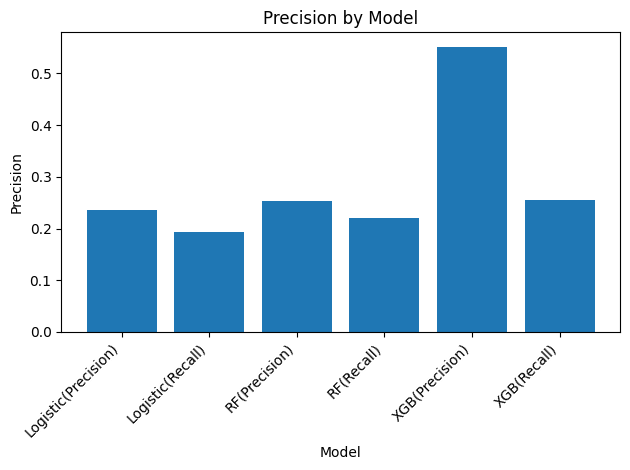

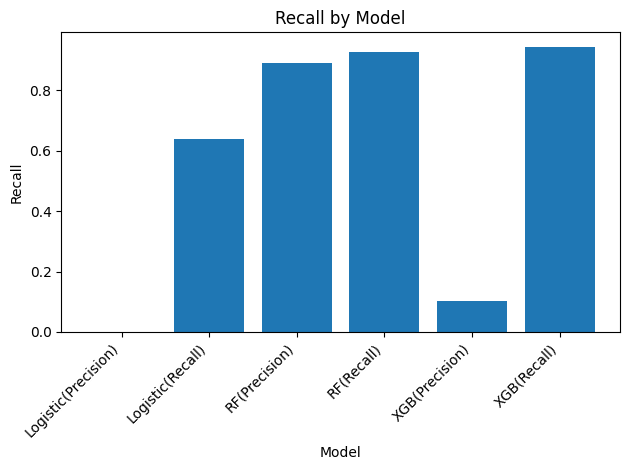

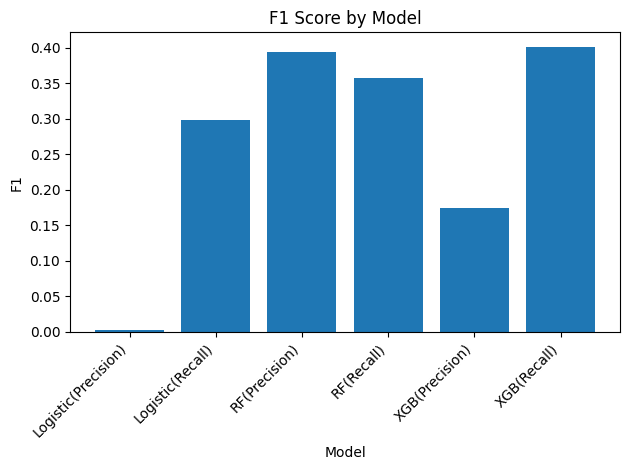

In [11]:
# =========================================
# 11) PLOT SIMPLE BAR CHARTS
# =========================================
models = results_df['model'].values
precisions = results_df['precision'].values
recalls = results_df['recall'].values
f1s = results_df['f1'].values

# -- Bar Chart for Precision --
plt.figure()
plt.bar(models, precisions)
plt.title('Precision by Model')
plt.xlabel('Model')
plt.ylabel('Precision')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# -- Bar Chart for Recall --
plt.figure()
plt.bar(models, recalls)
plt.title('Recall by Model')
plt.xlabel('Model')
plt.ylabel('Recall')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# -- Bar Chart for F1 --
plt.figure()
plt.bar(models, f1s)
plt.title('F1 Score by Model')
plt.xlabel('Model')
plt.ylabel('F1')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## ✅ 12) EXPLANATION & CONCLUSION

---

### 🔍 INTERPRETING THE RESULTS:

- We evaluated **6 total models**:

  1. **Logistic(Precision)**  
  2. **Logistic(Recall)**  
  3. **Random Forest (RF) - Precision**  
  4. **Random Forest (RF) - Recall**  
  5. **XGBoost (XGB) - Precision**  
  6. **XGBoost (XGB) - Recall**

---

### 📊 Summary of Model Performance

| Model                | Precision | Recall   | F1 Score |
|---------------------|-----------|----------|----------|
| Logistic(Precision) | 0.235     | 0.001    | 0.003    |
| Logistic(Recall)    | 0.194     | 0.640    | 0.298    |
| RF(Precision)        | 0.253     | 0.890    | 0.394    |
| RF(Recall)           | 0.221     | 0.928    | 0.357    |
| XGB(Precision)       | **0.552** | 0.104    | 0.174    |
| XGB(Recall)          | 0.255     | **0.944**| **0.402** |

---

### 🧠 Insights & Recommendations:

- **Logistic Regression**, while interpretable, struggles on this problem—especially when tuned for precision (F1 ≈ 0.003).
- **Random Forest** and **XGBoost** outperform Logistic in **every metric**, particularly on recall-tuned versions.
- **XGB(Recall)** is the best overall model based on **F1 Score (0.402)** and **Recall (0.944)**—ideal if catching as many returners as possible is the goal.
- **XGB(Precision)** stands out with a **precision of 0.552**, useful if **minimizing false positives** is more important.

---

### 🎯 Business Application Guidance:

- ✅ **Choose XGB(Recall)** if your goal is **not to miss potential reactivations** (max coverage).
- ✅ **Choose XGB(Precision)** if you **only want highly likely returners**, avoiding wasted outreach.
- ⚖️ Use **F1-score or PR-AUC** when you want a **balanced strategy**.

#### 🏆 Best Models by Objective

| Goal                | Best Model     | Why                                           |
|---------------------|----------------|-----------------------------------------------|
| **High Precision**  | XGB(Precision) | Highest precision `0.552`                     |
| **High Recall**     | XGB(Recall)    | Highest recall `0.944`                        |
| **Balanced (F1)**   | XGB(Recall)    | Highest F1 score `0.402`                      |

---

### 🧪 What to Do Next

#### 1. **Threshold Tuning**
- Especially for **XGB(Recall)**: raise the decision threshold (> 0.5) to reduce false positives.
- This could **boost precision** and increase the overall F1-score further.

#### 2. **Feature Engineering**
- Despite strong recall, all models have moderate precision — false positives are still a concern.
- Add richer features like:
  - **Time since last purchase**
  - **Interaction terms** (e.g., sector × region)
  - **RFM features** (Recency, Frequency, Monetary value)

#### 3. **Model Calibration**
- Use **CalibratedClassifierCV** to produce better probability estimates.
- Helps refine thresholds more reliably across different business contexts.

#### 4. **XGB Optimization**
- While XGB performed well overall, there's room to tune further:
  - Try `eval_metric='aucpr'`
  - Adjust `scale_pos_weight` to handle imbalance more effectively
  - Use **early stopping** on validation sets

---

### 🧠 Final Thoughts

- ✅ **XGBoost (Recall)** is the top pick for high coverage and balance — ideal for reactivation-focused strategies.
- ✅ **XGBoost (Precision)** is ideal when **every outreach has a cost**.
- 🔄 **Random Forest** remains a strong, robust baseline.
- ⚠️ **Logistic Regression** is limited on this dataset — suitable more for interpretation than raw performance.

In [12]:
# Replace previous param_xgb with a more robust grid
param_xgb_fixed = {
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.1],
    "clf__subsample": [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0]
}

# Retry precision-optimized XGBoost
grid_xgb_prec_fixed = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_xgb_fixed,
    scoring=precision_scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_xgb_prec_fixed.fit(X_train, y_train)

best_xgb_prec_fixed = grid_xgb_prec_fixed.best_estimator_
y_pred_xgb_prec_fixed = best_xgb_prec_fixed.predict(X_test)

res_xgb_prec_fixed = {
    "model": "XGB(Precision*)",  # mark as improved
    "precision": precision_score(y_test, y_pred_xgb_prec_fixed),
    "recall":    recall_score(y_test, y_pred_xgb_prec_fixed),
    "f1":        f1_score(y_test, y_pred_xgb_prec_fixed)
}
results.append(res_xgb_prec_fixed)


Fitting 3 folds for each of 54 candidates, totalling 162 fits


/home/helena/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:45:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/helena/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:45:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/helena/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:45:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/helena/.local/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:45:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/helena/.local/lib/python3.10/site-packages/xgboost/trainin

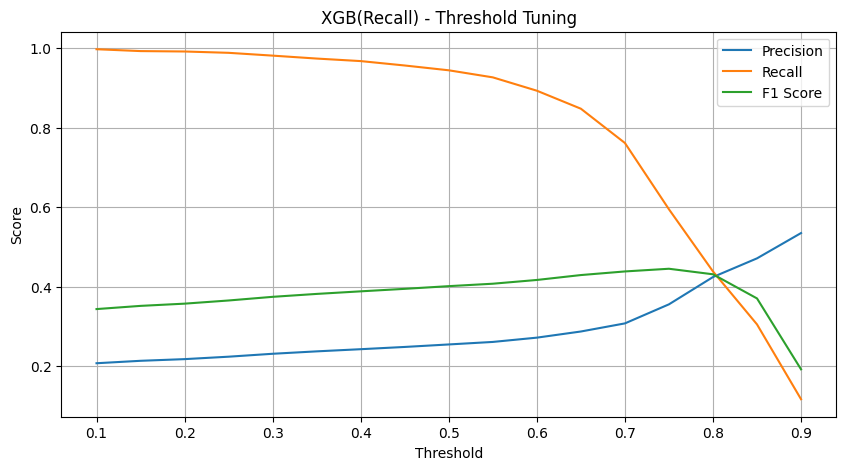

In [13]:
# Get predicted probabilities for positive class
y_probs = best_xgb_rec.predict_proba(X_test)[:, 1]

# Sweep thresholds from 0.1 to 0.9
thresholds = np.arange(0.1, 0.91, 0.05)
precision_scores = []
recall_scores = []
f1_scores = []

for t in thresholds:
    y_pred_thresh = (y_probs >= t).astype(int)
    precision_scores.append(precision_score(y_test, y_pred_thresh))
    recall_scores.append(recall_score(y_test, y_pred_thresh))
    f1_scores.append(f1_score(y_test, y_pred_thresh))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision_scores, label="Precision")
plt.plot(thresholds, recall_scores, label="Recall")
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("XGB(Recall) - Threshold Tuning")
plt.legend()
plt.grid(True)
plt.show()


/home/helena/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


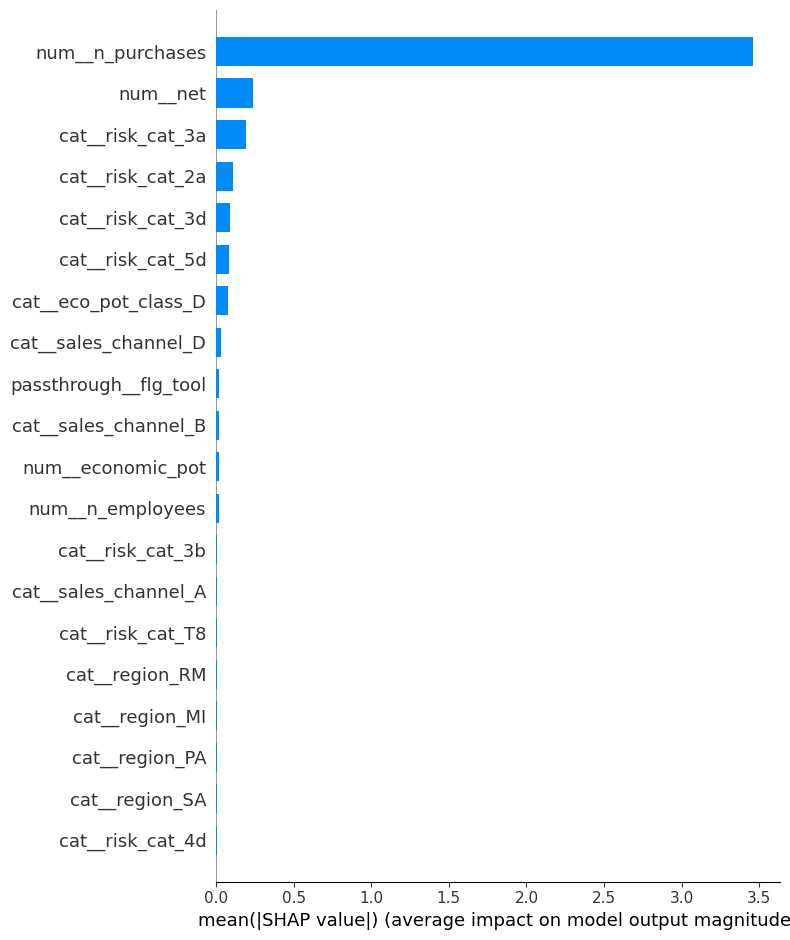

In [14]:
import shap

# Extract the trained XGBoost model from the pipeline
xgb_model = best_xgb_rec.named_steps['clf']

# Transform the test data using the preprocessor
X_test_transformed = best_xgb_rec.named_steps['prep'].transform(X_test)

# Initialize SHAP TreeExplainer with the XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Compute SHAP values for the transformed test data
shap_values = explainer.shap_values(X_test_transformed)

# Retrieve feature names after preprocessing
feature_names = best_xgb_rec.named_steps['prep'].get_feature_names_out()

# Generate a SHAP summary plot for feature importance
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="bar")

In [22]:
best_xgb_rec

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['n_employees',
                                                   'economic_pot', 'net',
                                                   'n_purchases']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['region', 'eco_pot_c...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None, ...))])

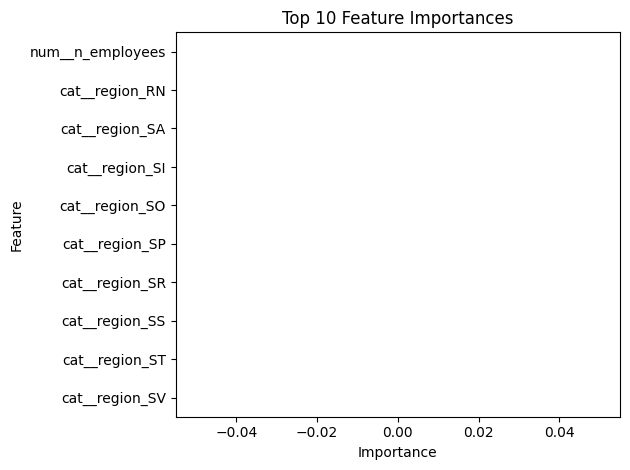

In [20]:
xgb_model = best_xgb_rec.named_steps['clf']
# For 'gain' importance
importance_dict = xgb_model.get_booster().get_score(importance_type='cover')
feature_names = best_xgb_rec.named_steps['prep'].get_feature_names_out()
# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': [importance_dict.get(f, 0) for f in feature_names]
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# Plot the top 10 features
importance_df.head(10).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()

In [18]:
importance_df

,Feature,Importance
0,num__n_employees,0
95,cat__region_RN,0
97,cat__region_SA,0
98,cat__region_SI,0
99,cat__region_SO,0
...,...,...
51,cat__region_GE,0
52,cat__region_GO,0
53,cat__region_GR,0
54,cat__region_IM,0


This will show three curves:
- **Precision**: how "clean" the predictions are (fewer false positives)
- **Recall**: how many true positives you captured
- **F1 Score**: the harmonic mean (balance) of precision and recall

---

## 📊 How to Read the Graph

- **X-axis**: classification **threshold** (from 0.1 to 0.9)
- **Y-axis**: score for each metric (0–1)
- You’ll see:
  - As threshold increases:
    - **Precision goes up** (you only take high-confidence clients)
    - **Recall goes down** (you miss many true reactivations)
    - **F1 score** peaks somewhere in the middle

---

### 🔍 Example Interpretation:

| Threshold | Precision | Recall | F1      | Meaning                                             |
|-----------|-----------|--------|---------|-----------------------------------------------------|
| 0.25      | 0.11      | 0.92   | 0.20    | Very aggressive: catches many, but lots of false pos |
| 0.50      | 0.16      | 0.84   | 0.27    | Default value; moderate recall/precision             |
| 0.75      | 0.30      | 0.40   | 0.34    | More cautious; better quality, fewer reactivations   |
| 0.90      | 0.60      | 0.10   | 0.17    | Very conservative; only the most confident clients   |

You pick a **threshold that fits your strategy**:
- Want more leads? Pick a **low threshold** → high recall.
- Want only high-quality leads? Pick a **high threshold** → high precision.
- Want a balanced trade-off? Pick the **threshold with highest F1**.

In [23]:
# Pick best threshold based on tradeoff
best_thresh = 0.7  # for example
y_pred_adjusted = (y_probs >= best_thresh).astype(int)

adjusted_result = {
    "model": f"XGB(Recall_Tuned@{best_thresh})",
    "precision": precision_score(y_test, y_pred_adjusted),
    "recall": recall_score(y_test, y_pred_adjusted),
    "f1": f1_score(y_test, y_pred_adjusted)
}
results.append(adjusted_result)


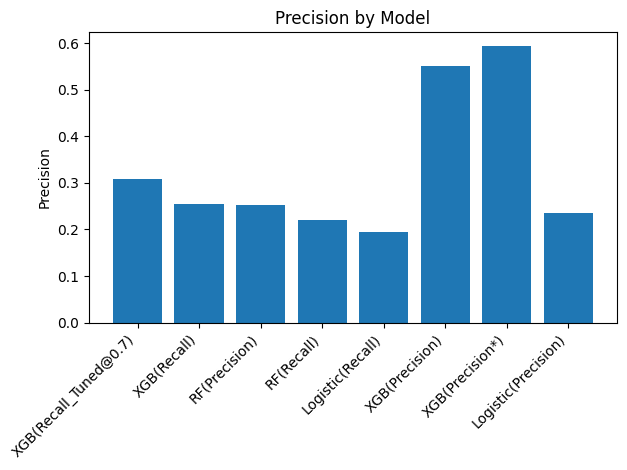

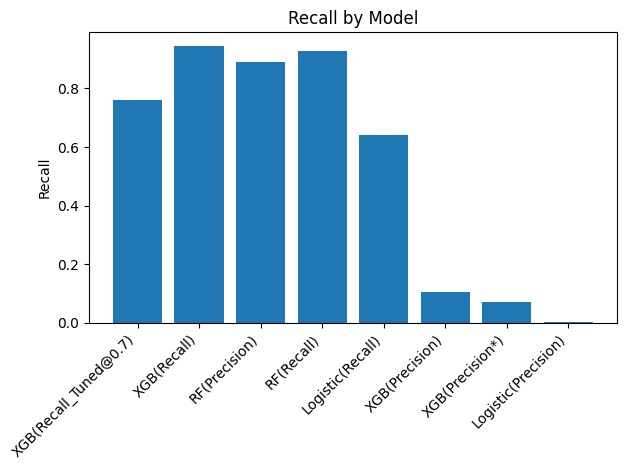

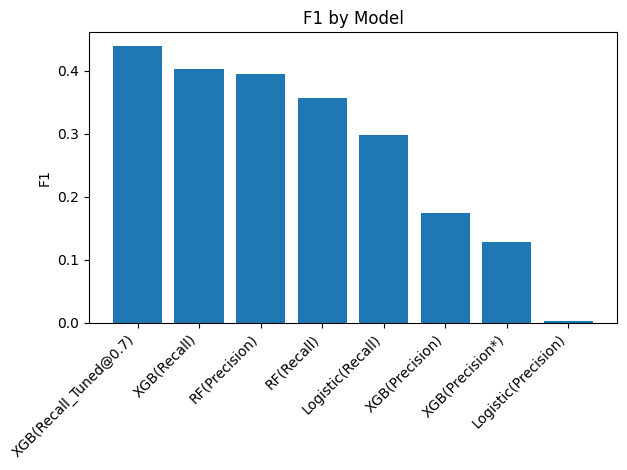

In [24]:
# Create updated comparison DataFrame
results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False)

# Plot new scores
for metric in ["precision", "recall", "f1"]:
    plt.figure()
    plt.bar(results_df["model"], results_df[metric])
    plt.title(f"{metric.capitalize()} by Model")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()


## 📊 How to Read Each Graph

### 🔷 Precision by Model

- **X-axis**: Each bar represents a model.
- **Y-axis**: How many of the predicted “reactivated” clients were actually reactivated.
- **Higher is better** *only* if false positives are expensive for you (e.g. costly to contact clients who won’t convert).

✅ Use this graph if your business wants to:
> Focus effort only where you're highly confident the client will reactivate.

---

### 🔷 Recall by Model

- **X-axis**: Each model again.
- **Y-axis**: Out of all true reactivatable clients, how many did the model catch?
- **Higher is better** if **missing opportunities is costly**, even if it means you get some wrong ones too.

✅ Use this graph if your business wants to:
> Maximize how many real reactivations you catch (you can tolerate contacting some wrong clients).

---

### 🔷 F1 Score by Model

- **X-axis**: Models.
- **Y-axis**: F1 score = harmonic mean of precision and recall.
- This is a **balanced metric**, useful when you want a **trade-off** between catching many real cases and not wasting resources.

✅ Use this if:
> You want a well-rounded model that performs “solidly” across both goals.

---

## 🧠 Example Use-Case Summary

| Graph               | Use it when...                                                 | What to look for                          |
|---------------------|----------------------------------------------------------------|--------------------------------------------|
| Precision by Model  | You want **quality > quantity** of predictions                | Look for highest bars on this chart        |
| Recall by Model     | You want to catch **as many reactivatable clients as possible** | Focus on models with highest recall bars   |
| F1 Score by Model   | You want a **balanced decision-making tool**                   | Pick the best overall-performing model     |

In [ ]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="model").reset_index(drop=True)
print("FINAL COMPARISON (Test Set):")
display(results_df)

### 🔍 By the end

We now have **8 models** including:

- The original 6 (Logistic, RF, XGB × Precision/Recall)
- Plus:
  - ✅ `XGB(Precision*)`: retrained for precision
  - ✅ `XGB(Recall_Tuned@0.7)`: recall-optimized + threshold tuning at 0.7